# 0.0. IMPORTS

In [55]:
import warnings
import pickle
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling  import SMOTE
from sklearn.preprocessing   import LabelEncoder
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import confusion_matrix, accuracy_score
from sklearn.metrics         import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score, KFold


warnings.filterwarnings( 'ignore' )
sns.set_theme(style="whitegrid", palette="pastel")

## 0.1 FUNCTIONS

In [2]:
# função que retorna o índice bmi para um valor de idade
def median(df, age):
    if age <= 1:
        return df.loc[(df.Age < 1)].Bmi.mean()
    elif age > 1 and age <=17:
        return df.loc[(df.Age > 1) & (df.Age <= 17)].Bmi.mean()
    elif age >= 18 and age < 30:
        return df.loc[(df.Age >= 18) & (df.Age < 30)].Bmi.mean()
    elif age >= 30 and age < 45:
        return df.loc[(df.Age >= 30) & (df.Age < 45)].Bmi.mean()
    elif age >= 45 and age < 65:
        return df.loc[(df.Age >= 45) & (df.Age < 65)].Bmi.mean()
    elif age >= 65:
        return df.loc[df.Age >= 65].Bmi.mean()


In [3]:
def age_group(age):
    if age <= 20:
        return 'Young'
    elif age > 20 and age <= 50:
        return 'Adult'
    elif age > 50:
        return 'Old'

## 0.2. LOADING DATA

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df.copy()

## 1.1. RENAME COLUMNS

In [6]:
columns_old = df1.columns
columns = lambda x: x.title()
columns_new = list(map(columns,columns_old))

# rename
df1.columns = columns_new

## 1.2. DATA DIMENSIONS

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 5110
Number of Cols: 12


## 1.3. DATA TYPES

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 5110 non-null   int64  
 1   Gender             5110 non-null   object 
 2   Age                5110 non-null   float64
 3   Hypertension       5110 non-null   int64  
 4   Heart_Disease      5110 non-null   int64  
 5   Ever_Married       5110 non-null   object 
 6   Work_Type          5110 non-null   object 
 7   Residence_Type     5110 non-null   object 
 8   Avg_Glucose_Level  5110 non-null   float64
 9   Bmi                4909 non-null   float64
 10  Smoking_Status     5110 non-null   object 
 11  Stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## 1.4. CHECK NA

In [9]:
df1.isnull().sum()

Id                     0
Gender                 0
Age                    0
Hypertension           0
Heart_Disease          0
Ever_Married           0
Work_Type              0
Residence_Type         0
Avg_Glucose_Level      0
Bmi                  201
Smoking_Status         0
Stroke                 0
dtype: int64

## 1.5. FILLING NA

In [10]:
# lista com o valor bmi para todas as entradas na coluna age
new_bmi = [median(df1, age) for age in df1.Age]

# data frame com a coluna bmi substituída pelos valores novos somente onde tem NaN
df1.Bmi = df1.Bmi.where(df1.Bmi.notna(), new_bmi)

In [11]:
df1.isnull().sum()

Id                   0
Gender               0
Age                  0
Hypertension         0
Heart_Disease        0
Ever_Married         0
Work_Type            0
Residence_Type       0
Avg_Glucose_Level    0
Bmi                  0
Smoking_Status       0
Stroke               0
dtype: int64

## 1.6. DESCRIPTIVE STATISTICS

In [12]:
df1.describe()

,Id,Age,Hypertension,Heart_Disease,Avg_Glucose_Level,Bmi,Stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.918626,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.720841,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.700000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.300000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# 2.0 FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

In [14]:
# column Gender
df2['Gender'] = df2['Gender'].map({'Male': 0, 'Female': 1, 'Other': 2})

# column Ever_Married
df2['Ever_Married'] = df2['Ever_Married'].map({'Yes': 1, 'No': 0})

# column Residence_type
df2['Residence_Type'] = df2['Residence_Type'].map({'Urban': 0, 'Rural': 1})

# removed columns id
df2.drop(columns='Id', inplace=True)

## 2.1. CHANGE DATA TYPES

In [15]:
df2['Gender'] = df2['Gender'].astype(int)
df2['Age'] = df2['Age'].astype(int)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             5110 non-null   int32  
 1   Age                5110 non-null   int32  
 2   Hypertension       5110 non-null   int64  
 3   Heart_Disease      5110 non-null   int64  
 4   Ever_Married       5110 non-null   int64  
 5   Work_Type          5110 non-null   object 
 6   Residence_Type     5110 non-null   int64  
 7   Avg_Glucose_Level  5110 non-null   float64
 8   Bmi                5110 non-null   float64
 9   Smoking_Status     5110 non-null   object 
 10  Stroke             5110 non-null   int64  
dtypes: float64(2), int32(2), int64(5), object(2)
memory usage: 399.3+ KB


# 3.0. EXPLORATORY ANALYSIS

In [17]:
df3 = df2.copy()

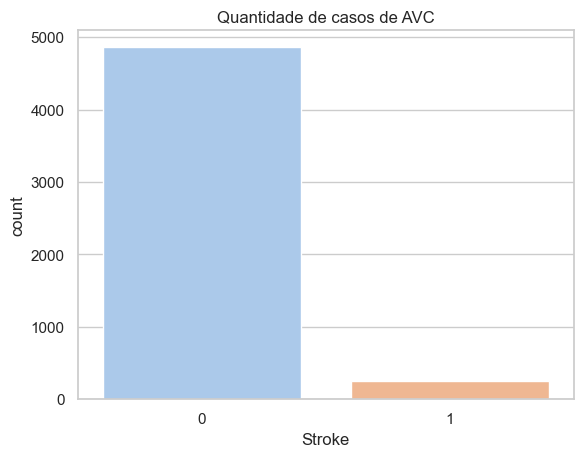

In [18]:
sns.countplot(x = 'Stroke', data= df3)
plt.title('Quantidade de casos de AVC')
plt.show()

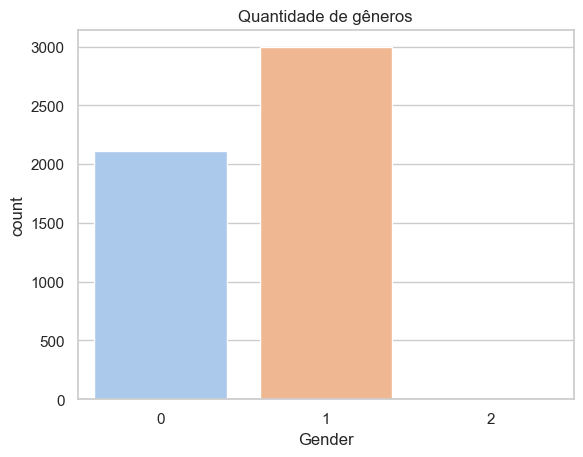

In [19]:
sns.countplot(x = 'Gender', data= df3)
plt.title('Quantidade de gêneros')
plt.show()

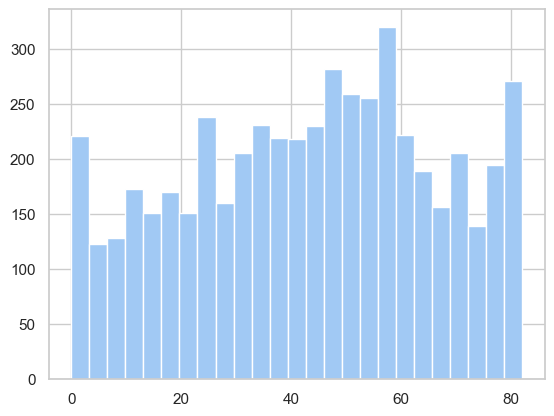

In [20]:
df3['Age'].hist(bins=25)
plt.show();

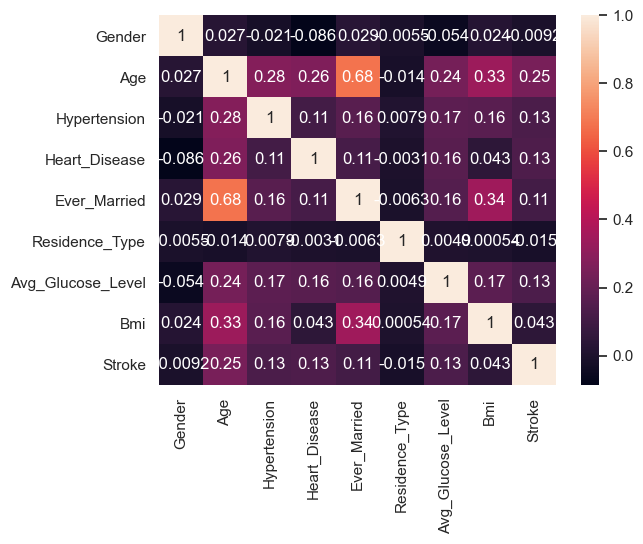

<Figure size 2000x2000 with 0 Axes>

In [21]:
sns.heatmap(df3.corr( method='pearson' ), annot=True)
plt.figure(figsize=(20, 20))
plt.show();

## 3.1. QUESTIONS AND ANSWERS

### 3.1.1 - PESSOAS MAIS VELHAS TÊM MAIS CHANCES DE TER AVC

**TRUE** PESSOAS MAIS VELHAS TIVERAM MAIS AVC.

In [22]:
df3['Age_group'] = df3['Age'].apply(lambda x: age_group(x))

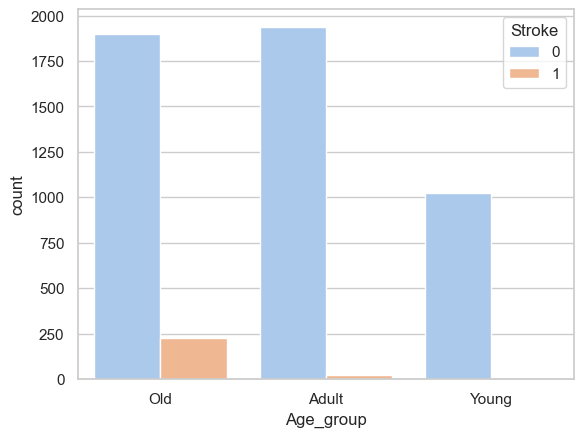

In [23]:
sns.countplot(x='Age_group', data=df3, hue='Stroke')
plt.show()

### 3.1.2 - PESSOAS CASADAS TÊM MAIS CHANCES DE TER AVC.

**TRUE** PESSOAS CASADAS OU QUE JÁ FORAM CASADAS TIVERAM MAIS AVC.

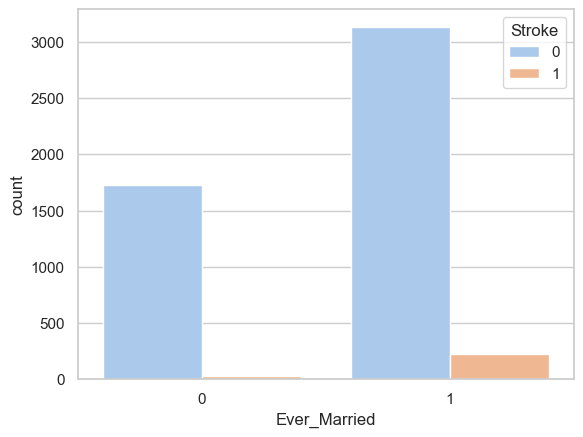

In [24]:
sns.countplot(x='Ever_Married', data=df3, hue='Stroke')
plt.show()

### 3.1.3 - FUMANTES TÊM MAIS CHANCES DE TER AVC.

**FALSE** PESSOAS FUMANTES TIVERAM MENOS AVC DO QUE PESSOAS QUE NUNCA FUMARAM.

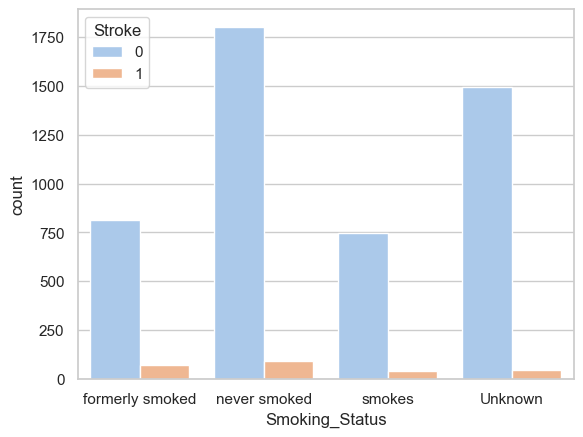

In [25]:
sns.countplot(x='Smoking_Status', data=df3, hue='Stroke')
plt.show()

### 3.1.4 - PESSOAS HIPERTENSAS TÊM MAIS CHANCES DE TER AVC.

**FALSE** PESSOAS NÃO-HIPERTENSAS TIVERAM MAIS AVC.

In [26]:
aux = df3.loc[df3['Hypertension'] == 1]
aux['Stroke'].value_counts()

0    432
1     66
Name: Stroke, dtype: int64

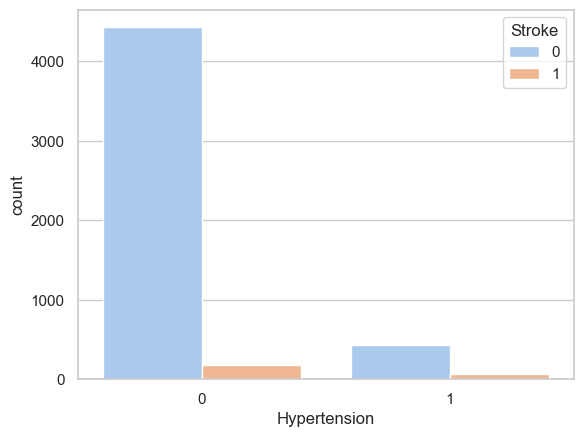

In [27]:
sns.countplot(x='Hypertension', data=df3, hue='Stroke')
plt.show()

### 3.1.5 - PESSOAS COM DOENÇAS CARDÍACAS TÊM MAIS CHANCES DE TER AVC.

**TRUE** PESSOAS COM PROBLEMAS CARDÍACOS TIVERAM MAIS AVC.

OBS: DE MODO PROPORCIONAL.

In [28]:
aux = df3.loc[df3['Heart_Disease'] == 1]
aux['Stroke'].value_counts()

0    229
1     47
Name: Stroke, dtype: int64

In [29]:
47/(47+229)

0.17028985507246377

In [30]:
aux = df3.loc[df3['Heart_Disease'] == 0]
aux['Stroke'].value_counts()

0    4632
1     202
Name: Stroke, dtype: int64

In [31]:
202/(202+4632)

0.041787339677285894

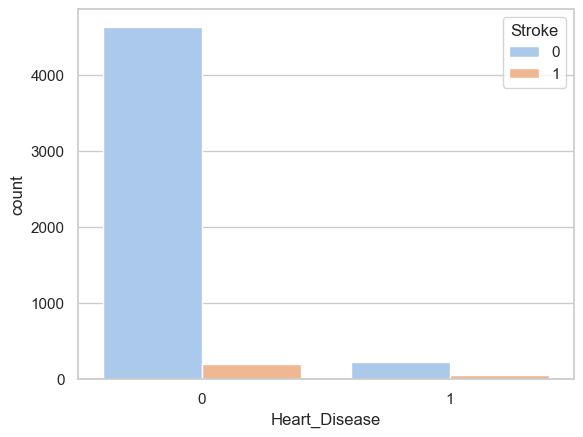

In [32]:
sns.countplot(x='Heart_Disease', data=df3, hue='Stroke')
plt.show()

# 4.0. DATA PREPARATION

In [33]:
df4 = df2.copy()

## 4.1. DATE STANDARD 

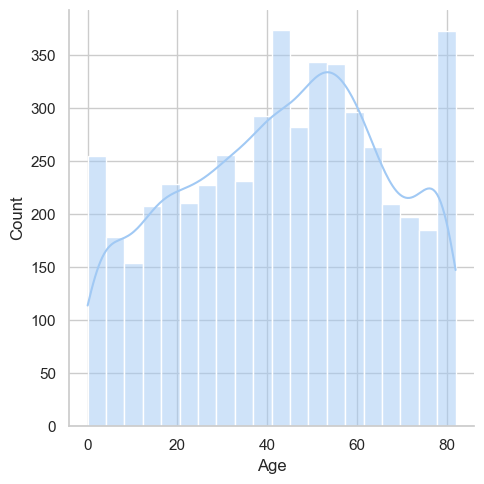

In [34]:
sns.displot(x='Age', data=df4, kde=True)
plt.show()

In [35]:
standardscaler_age = StandardScaler()
df4['Age'] = standardscaler_age.fit_transform(df4[['Age']].values)

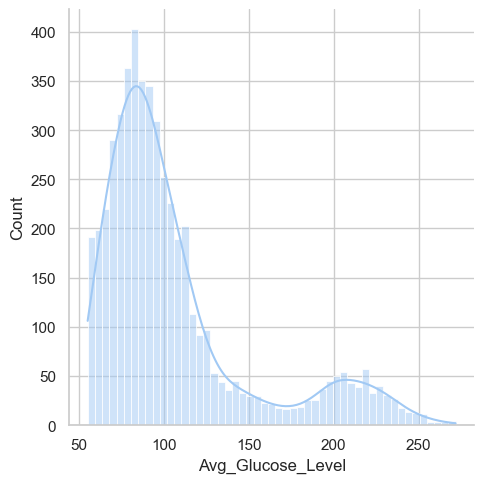

In [36]:
sns.displot(x='Avg_Glucose_Level', data=df4, kde=True)
plt.show()

In [37]:
standardscaler_avg = StandardScaler()
df4['Avg_Glucose_Level'] = standardscaler_avg.fit_transform(df4[['Avg_Glucose_Level']].values)

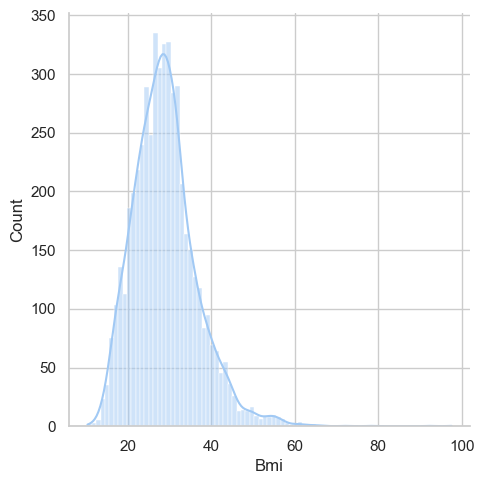

In [38]:
sns.displot(x='Bmi', data=df4, kde=True)
plt.show()

In [39]:
standardscaler_bmi = StandardScaler()
df4['Bmi'] = standardscaler_bmi.fit_transform(df4[['Bmi']].values)

## 4.2. ENCONDING

In [40]:
df4 = pd.get_dummies(df4, columns=['Work_Type'])

In [41]:
le = LabelEncoder()
df4['Smoking_Status'] = le.fit_transform(df4['Smoking_Status'])

# 5.0. SPLIT DF INTO TRAINING AND TEST

In [42]:
df5 = df4.copy()

In [43]:
df5

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Residence_Type,Avg_Glucose_Level,Bmi,Smoking_Status,Stroke,Work_Type_Govt_job,Work_Type_Never_worked,Work_Type_Private,Work_Type_Self-employed,Work_Type_children
0,0,1.050950,0,1,1,0,2.706375,0.994986,1,1,0,0,1,0,0
1,1,0.785835,0,0,1,1,2.121559,0.341982,2,1,0,0,0,1,0
2,0,1.625367,0,1,1,1,-0.005028,0.463903,2,1,0,0,1,0,0
3,1,0.255604,0,0,1,0,1.437358,0.710015,3,1,0,0,1,0,0
4,1,1.581181,1,0,1,1,1.501184,-0.637121,2,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,1.625367,1,0,1,0,-0.494658,0.082701,2,0,0,0,1,0,0
5106,1,1.669553,0,0,1,0,0.420775,1.435395,2,0,0,0,0,1,0
5107,1,-0.362999,0,0,1,1,-0.511443,0.217792,2,0,0,0,0,1,0
5108,0,0.343976,0,0,1,1,1.328257,-0.429869,1,0,0,0,1,0,0


## 5.1 SMOTE - BALANCING DATA

In [44]:
X = df5.iloc[:, [0,1,2,3,4,5,6,7,8,10,11,12,13,14,14]].values
y = df5.iloc[:, 9].values

In [45]:
smt = SMOTE()
X, y = smt.fit_resample(X, y)

In [46]:
X.shape, y.shape

((9722, 15), (9722,))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# 6.0 MACHINE LEARNING MODEL

## 6.1. RANDOM FOREST

In [48]:
clf = RandomForestClassifier(n_estimators = 10,criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

In [49]:
accuracy_score(y_test, predict)

0.9532133676092545

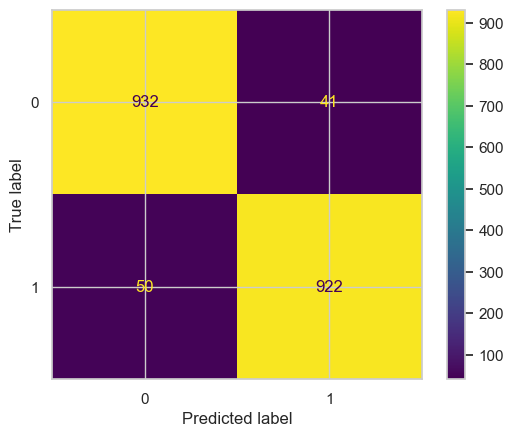

In [50]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# 7.0. GRIDSEACHCV

In [51]:
params = {
    'n_estimators': [50, 100, 200, 300],
    'criterion'   : ['entropy', 'gini'],
    'max_depth'   : [3, 5, 9],    
}

In [52]:
grid_search = GridSearchCV(estimator= RandomForestClassifier(), param_grid = params, cv=10)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}
0.896628411556469


# 8.0. CROSS VALIDATION

In [54]:
result = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    clf = RandomForestClassifier(criterion= 'gini', max_depth= 9, n_estimators= 200)
    scores = cross_val_score(clf, X, y, cv=kfold)
    result.append(scores.mean())

In [56]:
result = pd.DataFrame(data=result, columns=['Resultado'])

In [57]:
result.describe()

,Resultado
count,30.000000
mean,0.895851
std,0.000950
min,0.894261
25%,0.895135
50%,0.895701
75%,0.896345
max,0.897757


# 9.0 FINAL CLASSIFIER

In [58]:
clf = RandomForestClassifier(criterion= 'gini', max_depth= 9, n_estimators= 200)
pickle.dump(clf, open('final_classifier.sav', 'wb'))